In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import time
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
from spacetime.spacetime_att import SpaceTime
from spacetime.simulate_att import Simulator
# from spacetime.models_att2 import MLPEncoder, MLPDecoder, AutoEncoder
from spacetime.training_att import LagrangeLoss, ActionOpt
from spacetime.training_att import train, truth_evaluation
from spacetime.utils_att import Parameters
from spacetime.sampler import NodeData, GraphSampler

simulating a random 3-degree erdos-renyi dag with range (0.5, 2.0) (seed 3)
simulating 7500 samples from a linear-gauss sem with nonlinear_1 causal effects


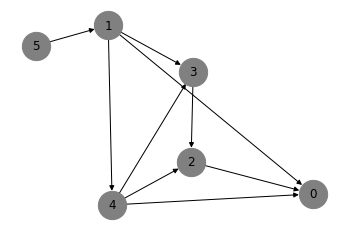

In [4]:
n_nodes=6
node_list = list(range(n_nodes))
from spacetime.training_att import h_A, h_A_timed

sim_params = Parameters(graph_type='erdos-renyi', graph_degree=3, edge_types=2, 
                        sem_type='nonlinear_2', x_dims=1, sem_noise='linear-gauss', 
                        noise_scale = 0.6, sample_size=7500, seed=42)

mod_params = Parameters(n_nodes=n_nodes, x_dims=1, h_dims=32, z_dims=1, graph_threshold=0.3)

trn_params = Parameters(batch_size=100, epochs=5)

opt_params = Parameters(constraint=lambda x: h_A(x, n_nodes),
                        lr=3e-3, l=1e-2, c=1.0, h=np.inf, tau=1e-10, 
                        max_iters=50, h_tol=1e-8)

sim = Simulator.random(n_nodes, degree=3, seed=3)
sim.sem(7500, 'nonlinear_1', noise_scale=0.8)
g = SpaceTime.simulation(sim)
# g.adj
g.draw_graph()

In [5]:
col_plot_dict = {0:(4,2), 1:(4,1), 2:(2,1), 3:(3,0)}
mutilate = 1
observe = 2
latent = 0

In [6]:
train_loader, test_loader = g.data_loader(trn_params.batch_size)

In [7]:
####################################################################
### Ripped heavily from https://github.com/fishmoon1234/DAG-GNN
####################################################################

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

_EPS = 1e-10

class AutoEncoder(nn.Module):
    def __init__(self, mod_params):
        super(AutoEncoder, self).__init__()
        self.embedder = LinearBlock(mod_params.x_dims, mod_params.h_dims, mod_params.z_dims).double()
        self.debedder = LinearBlock(mod_params.z_dims, mod_params.h_dims, mod_params.x_dims).double()
        self.semblock = SEMBlock(mod_params.n_nodes, d_causal=int(2*mod_params.n_nodes)).double()
        
        self.ff = LinearBlock(mod_params.z_dims, mod_params.h_dims, mod_params.z_dims).double()
     
    def forward(self, x):
        s = self.embedder(x)
#         z = self.semblock(s, op='decode')
        z = self.semblock(s, op='causal')
        xx = self.debedder(z)
        return xx, s, self.semblock.adj_p()
    
    def encode(self, x):
        x = self.embedder(x)
#         x = self.semblock(x, op='encode')
        return x
    
    def decode(self, z):
#         zz = self.semblock(z, op='decode')
#         z = self.ff(z)
        z = self.semblock(z, op='causal')
        z = self.debedder(z)
        return z

#     def forward(self, x):
#         z = self.encode(x)
#         xx = self.decode(z)
#         return xx, z, self.semblock.adj_p()
    
class LinearBlock(nn.Module):
    def __init__(self, n_in, n_hid, n_out, dropout=0.0):
        super(LinearBlock, self).__init__()
        self.w_1 = nn.Linear(n_in, n_hid)
        self.w_2 = nn.Linear(n_hid, n_out)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.0)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

def rand_norm(mu, std, x, y):
    return torch.normal(mu, torch.Tensor([std]*x*y).view(x, y))
                        
class SEMBlock(nn.Module):
    """SEM operator module."""
    def __init__(self, n_nodes, d_causal):
        super(SEMBlock, self).__init__()
        self.q = nn.Parameter(rand_norm(0, 0.1, n_nodes, d_causal).double(), requires_grad=True)
        self.k = nn.Parameter(rand_norm(0, 0.1, n_nodes, d_causal).double(), requires_grad=True)
        self.adj = nn.Parameter(rand_norm(0, 0.1, n_nodes, n_nodes).double(), requires_grad=True)
        self.n_nodes = n_nodes

    def _check_nan(self):
        if torch.sum(self.q!=self.q):
            raise ValueError('nan error \n')
            
    def bmm(self, m, x):
        return torch.einsum('ij,ajc->aic', m, x)
            
    def atanh(self, x):
        return 0.5*torch.log1p((2*x)/(1-x))
    
    def adj_p(self):
#         return torch.sinh(3*torch.matmul(self.q, self.k.transpose(-2,-1)))
#         return torch.sinh(3*self.adj)
        return torch.matmul(self.q, self.k.transpose(-2,-1))
#         return self.adj

    def op(self):
        return torch.eye(self.n_nodes).double()-(self.adj_p().transpose(-2,-1))
    
    def _encode_sem(self, x):
        self._check_nan
        z = self.bmm(self.op(), x)
        return z
    
    def _decode_sem(self, x):
        self._check_nan
        x = self.bmm(self.op().inverse(), x)
        return x
    
    def _decode_causal(self, x):
        self._check_nan
        x = self.bmm(self.adj_p().transpose(-2,-1), x)
        return x
        
    def forward(self, x, op=None):
        if op is None:
            raise ValueError("choose op")
            
        if op=='encode':
            return self._encode_sem(x)
        
        elif op=='decode':
            return self._decode_sem(x)
        
        elif op=='causal':
            return self._decode_causal(x)
        
        else:
            raise ValueError("invalid op")

In [8]:
n_trials = 5

loss_log = {k:[] for k in ('elbo', 'kld', 'nll', 'lr')}
param_log = {k:[] for k in ('lr', 'l', 'c', 'h')}

shd_trials, err_trials = list(), list()
graph_trials = list()

for trial in range(n_trials):
    shd_train, err_train = list(), list()
    graph_train = list()
    #===================================
    # load modules
    #===================================

    autoencoder = AutoEncoder(mod_params)
    optimizerL = ActionOpt(autoencoder, opt_params, h_factor=0.25*(1), c_factor=10.0/(1))
    lossL = LagrangeLoss(opt=optimizerL)
    
    #===================================
    # train model
    #===================================
    
    t_total = time.time()
    while optimizerL._iter < optimizerL.max_iter:
        for epoch in range(trn_params.epochs):
            train(autoencoder, train_loader, lossL)
            shd, err = truth_evaluation(g.adj, optimizerL, 0.1, norm=True)
            shd_train.append(shd)
            err_train.append(err)
            graph_train.append(optimizerL.adj.data.clone())
        
        print("Iteration: %s, Best Epoch: %s/%s"%(optimizerL._iter, optimizerL.best_epoch, trn_params.epochs))
        print("   ELBO: {:.7f}, KL: 10^{:.3f}, NLL: 10^{:.3f} || h: 10^{:.3f}, c: 10^{:.3f}, l: {:.7f}, lr: {:.7f}".format(
            optimizerL.min_elbo, np.log10(optimizerL.min_kld), np.log10(optimizerL.min_nll),
            np.log10(optimizerL.h), np.log10(optimizerL.c), optimizerL.l, optimizerL.log['lr'][-1])
        )

        # update parameters
        optimizerL.iterate()
        if optimizerL.h <= optimizerL.h_tol or optimizerL._iter > 10:
            break

    print("\nTrial %s finished in %s seconds"%(trial, time.time() - t_total))
    print('Best ELBO Stats: shd %s err %s\n'%(shd, err))

    shd_trials.append(shd_train)
    err_trials.append(err_train)
    graph_trials.append(optimizerL.show_adj(0.0))
    
    for k,v in loss_log.items():
        v += [optimizerL.log[k]]
        
    for k,v in param_log.items():
        v += [optimizerL.log[k]]
    
pass;

/home/q1park/spacetime/spacetime/training_att.py:207: RuntimeWarning: invalid value encountered in true_divide
  test_adj /= np.max(test_adj)


Iteration: 0, Best Epoch: 4/5
   ELBO: 0.0965585, KL: 10^0.827, NLL: 10^-1.015 || h: 10^inf, c: 10^0.000, l: 0.0100000, lr: 0.0030000
Iteration: 1, Best Epoch: 4/5
   ELBO: 0.0410162, KL: 10^0.827, NLL: 10^-1.387 || h: 10^-3.207, c: 10^0.000, l: 0.0106212, lr: 0.0030000
Iteration: 2, Best Epoch: 4/5
   ELBO: 0.0086703, KL: 10^0.827, NLL: 10^-2.062 || h: 10^-3.207, c: 10^1.000, l: 0.0106212, lr: 0.0015000
Iteration: 3, Best Epoch: 3/5
   ELBO: 0.0046780, KL: 10^0.827, NLL: 10^-2.330 || h: 10^-3.207, c: 10^2.000, l: 0.0106212, lr: 0.0010000
Iteration: 4, Best Epoch: 2/5
   ELBO: 0.0032312, KL: 10^0.827, NLL: 10^-2.491 || h: 10^-3.207, c: 10^3.000, l: 0.0106212, lr: 0.0007500
Iteration: 5, Best Epoch: 4/5
   ELBO: 0.0026337, KL: 10^0.827, NLL: 10^-2.579 || h: 10^-3.879, c: 10^3.000, l: 0.1426069, lr: 0.0007500
Iteration: 6, Best Epoch: 1/5
   ELBO: 0.0018478, KL: 10^0.827, NLL: 10^-2.733 || h: 10^-3.879, c: 10^4.000, l: 0.1426069, lr: 0.0006000
Iteration: 7, Best Epoch: 1/5
   ELBO: 0.001

/home/q1park/spacetime/spacetime/training_att.py:207: RuntimeWarning: divide by zero encountered in true_divide
  test_adj /= np.max(test_adj)


Iteration: 0, Best Epoch: 4/5
   ELBO: 0.1152462, KL: 10^0.658, NLL: 10^-0.938 || h: 10^inf, c: 10^0.000, l: 0.0100000, lr: 0.0030000
Iteration: 1, Best Epoch: 4/5
   ELBO: 0.0401589, KL: 10^0.658, NLL: 10^-1.396 || h: 10^-3.090, c: 10^0.000, l: 0.0108121, lr: 0.0030000
Iteration: 2, Best Epoch: 4/5
   ELBO: 0.0111261, KL: 10^0.658, NLL: 10^-1.954 || h: 10^-3.090, c: 10^1.000, l: 0.0108121, lr: 0.0015000
Iteration: 3, Best Epoch: 4/5
   ELBO: 0.0054410, KL: 10^0.658, NLL: 10^-2.264 || h: 10^-3.090, c: 10^2.000, l: 0.0108121, lr: 0.0010000
Iteration: 4, Best Epoch: 3/5
   ELBO: 0.0040941, KL: 10^0.658, NLL: 10^-2.388 || h: 10^-3.800, c: 10^2.000, l: 0.0266471, lr: 0.0010000
Iteration: 5, Best Epoch: 2/5
   ELBO: 0.0027332, KL: 10^0.658, NLL: 10^-2.563 || h: 10^-3.800, c: 10^3.000, l: 0.0266471, lr: 0.0007500
Iteration: 6, Best Epoch: 2/5
   ELBO: 0.0022621, KL: 10^0.658, NLL: 10^-2.645 || h: 10^-3.800, c: 10^4.000, l: 0.0266471, lr: 0.0006000
Iteration: 7, Best Epoch: 1/5
   ELBO: 0.001

21.0000 +- 0.0000
3.3067 +- 0.0033


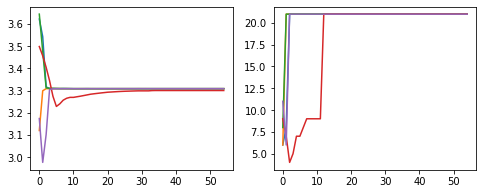

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (8,3))

for trial in range(n_trials):
    axs[0].plot(range(len(err_trials[trial][:])), err_trials[trial][:])
    axs[1].plot(range(len(shd_trials[trial][:])), shd_trials[trial][:])
    
shd_finals = [shd_trials[i][-1] for i in range(n_trials)]
err_finals = [err_trials[i][-1] for i in range(n_trials)]
print("{:0.4f} +- {:0.4f}".format(np.mean(shd_finals), np.std(shd_finals)))
print("{:0.4f} +- {:0.4f}".format(np.mean(err_finals), np.std(err_finals)))
pass;

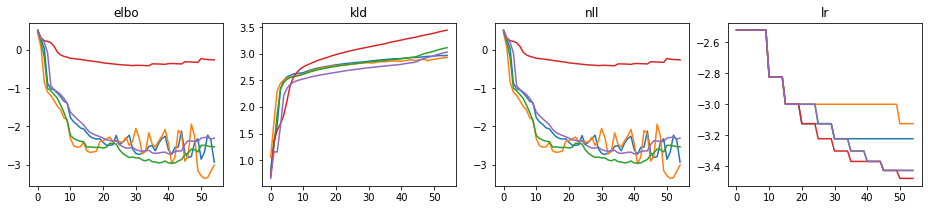

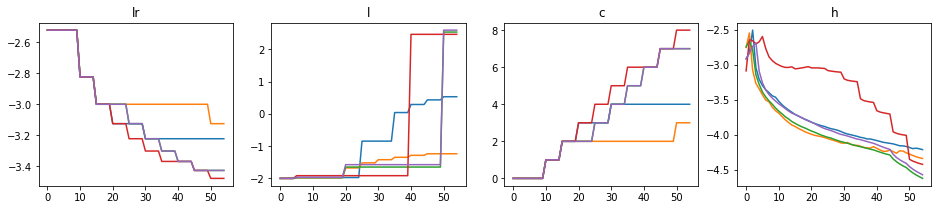

In [10]:
fig, axs = plt.subplots(1, 4, figsize = (16,3))

for i, (k,v) in enumerate(loss_log.items()):
    axs[i].set_title(r'%s'%k)
    for trial in range(n_trials):
        axs[i].plot(range(len(v[trial])), np.log10(v[trial]))
plt.show()

fig, axs = plt.subplots(1, 4, figsize = (16,3))

for i, (k,v) in enumerate(param_log.items()):
    axs[i].set_title(r'%s'%k)
    for trial in range(n_trials):
        axs[i].plot(range(len(v[trial])), np.log10(v[trial]))
pass;

In [11]:
testdata = iter(train_loader)

In [12]:
data, _ = next(testdata)
preds, z_train, origin_A = autoencoder(data.double())  

In [18]:
data[:2]
preds[:2]

tensor([[[ 0.4492],
         [ 0.8546],
         [ 0.7756],
         [-1.2555],
         [ 1.7497],
         [ 1.4112]],

        [[-0.3189],
         [ 0.5215],
         [ 1.3301],
         [-0.8594],
         [ 0.5095],
         [ 0.3201]]])

tensor([[[ 0.4773],
         [ 0.8526],
         [ 0.7872],
         [-1.3260],
         [ 1.7568],
         [ 1.3939]],

        [[-0.3095],
         [ 0.5249],
         [ 1.3366],
         [-0.9078],
         [ 0.5209],
         [ 0.3269]]], dtype=torch.float64, grad_fn=<SliceBackward>)

In [13]:
def threshold(adj, threshold, norm=False):
    if norm:
        clipped = adj/torch.max(torch.abs(adj))
    else:
        clipped = adj
    return nn.Threshold(threshold, 0.0)(clipped)-nn.Threshold(threshold, 0.0)(-clipped)

In [17]:
threshold(graph_trials[0], 0.0001, norm=False)
# threshold(graph_trials[1], 0.2, norm=True)

threshold(g.adj, 0.01, norm=False)

tensor([[0.0032, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0032, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0032, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0032, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0032, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0032]], dtype=torch.float64)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.3794,  0.0000,  0.0000,  1.1819,  0.8081,  0.0000],
        [ 1.2711,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0604,  0.0000,  0.0000,  0.0000],
        [-0.9887,  0.0000,  0.5923,  0.8640,  0.0000,  0.0000],
        [ 0.0000, -1.4757,  0.0000,  0.0000,  0.0000,  0.0000]])

In [15]:
blah

NameError: name 'blah' is not defined

## SEM Evaluation

In [ ]:
g_learned = SpaceTime.adjacency(optimizerL.show_adj(0.2).numpy())
g_learned.draw_graph()

In [ ]:
data, _ = next(testdata)
preds, z_train, origin_A = autoencoder(data.double()) 

In [ ]:
autoencoder.eval()

data = next(iter(test_loader))[0].double()
preds, noise, _ = autoencoder(data.double()) 
pass;

In [ ]:
X_train = NodeData(g.data, bins=10)
XX_train = NodeData(preds.detach().numpy(), bins=10)
Z_learned = NodeData(noise.detach().numpy(), bins=10)
X_learned = NodeData(preds.detach().numpy(), bins=10)

pX_train = GraphSampler(g, X_train)
pXX_train = GraphSampler(g, XX_train)
pZ_learned = GraphSampler(g_learned, Z_learned)
pX_learned = GraphSampler(g_learned, X_learned)

In [ ]:
Z_resampled_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000), bins = Z_learned.edges())
Z_resampled_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000), bins = Z_learned.edges())

In [ ]:
pZ_resampled_cdf = GraphSampler(g_learned, Z_resampled_cdf)
pZ_resampled_pdf = GraphSampler(g_learned, Z_resampled_pdf)

In [ ]:
preds_resampled_cdf = autoencoder.decode(torch.Tensor(Z_resampled_cdf.data()).double())
preds_resampled_pdf = autoencoder.decode(torch.Tensor(Z_resampled_pdf.data()).double())
X_resampled_cdf = NodeData(preds_resampled_cdf.detach().numpy(), bins=X_train.edges())
X_resampled_pdf = NodeData(preds_resampled_pdf.detach().numpy(), bins=X_train.edges())

pX_resampled_cdf = GraphSampler(g_learned, X_resampled_cdf)
pX_resampled_pdf = GraphSampler(g_learned, X_resampled_pdf)

In [ ]:
fig, axs = plt.subplots(2, 4, sharex='col', sharey='col', figsize = (16,6))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_Z(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pZ_learned.get_contour_conditional(d,c), levels=50)
#     axs[1][col].set_title(r'$P_Z(%s|%s)$    (cdf resampled histo)'%(d,c))
#     axs[1][col].contour(*pZ_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[1][col].contour(*pZ_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (preds histo)'%(d,c))
    axs[1][col].contour(*pXX_train.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
# plt.plot(pX_train.node_data.axes(0)[0], pX_train.histogram.compute_joint(0)[1])
# plt.plot(pX_train.node_data.axes(1)[0], pX_train.histogram.compute_joint(1)[1])
# plt.show()
# plt.plot(pX_mutil.node_data.axes(0)[0], pX_mutil.histogram.compute_joint(0)[1])
# plt.plot(pX_mutil.node_data.axes(1)[0], pX_mutil.histogram.compute_joint(1)[1])
# pass;

In [ ]:
# truth = pX.histogram.compute_conditional(4,(2,))[1]
# generated = pX_new.histogram.compute_conditional(4,(2,))[1]
# _, truth_ = pX.histogram._epsilonize((), truth)
# _, generated_ = pX.histogram._epsilonize((), generated)
# np.sum(truth_*np.log((truth_/generated_)))/np.prod(truth.shape)

In [ ]:
# np.sum(truth)
# np.sum(truth_*np.log((truth_/generated_)), axis=0, keepdims=True)
# np.exp(np.sum(-truth_*np.log((truth_/(truth_*0.1)))))

In [ ]:
blah

## Graph Mutilation Tests

In [ ]:
sim_mutil = Simulator(g.mutilate(mutilate).numpy())
sim_mutil.sem(7500, 'nonlinear_2')
g_mutil = SpaceTime.simulation(sim_mutil)
g_mutil.adj
g_mutil.draw_graph()

In [ ]:
g_learned.draw_graph()

g_learned_mutil = SpaceTime.adjacency(g_learned.mutilate(mutilate).numpy())
g_learned_mutil.draw_graph()

In [ ]:
X_mutil = NodeData(g_mutil.data, bins=10)
pX_mutil = GraphSampler(g, X_mutil)

In [ ]:
Z_resampled_mutil_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
Z_resampled_mutil_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
pZ_resampled_mutil_cdf = GraphSampler(g_learned, Z_resampled_mutil_cdf)
pZ_resampled_mutil_pdf = GraphSampler(g_learned, Z_resampled_mutil_pdf)

In [ ]:
preds_resampled_mutil_cdf = autoencoder.decode(torch.Tensor(Z_resampled_mutil_cdf.data()).double(), 
                                       g_learned_mutil.adj, Wa_train)
preds_resampled_mutil_pdf = autoencoder.decode(torch.Tensor(Z_resampled_mutil_pdf.data()).double(), 
                                       g_learned_mutil.adj, Wa_train)
X_resampled_mutil_cdf = NodeData(preds_resampled_mutil_cdf.detach().numpy(), bins=X_learned.edges())
X_resampled_mutil_pdf = NodeData(preds_resampled_mutil_pdf.detach().numpy(), bins=X_learned.edges())
pX_resampled_mutil_cdf = GraphSampler(g_learned_mutil, X_resampled_mutil_cdf)
pX_resampled_mutil_pdf = GraphSampler(g_learned_mutil, X_resampled_mutil_pdf)

In [ ]:
fig, axs = plt.subplots(4, 4, sharex='col', sharey='col', figsize = (16,12))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(d,c))
    axs[1][col].contour(*pX_mutil.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_mutil_cdf.get_contour_conditional(d,c), levels=50)
    axs[3][col].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(d,c))
    axs[3][col].contour(*pX_resampled_mutil_pdf.get_contour_conditional(d,c), levels=50)
    
pass;

In [ ]:
fig, axs = plt.subplots(3, 3, sharex='col', sharey='col', figsize = (12,9))

axs[0][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[0][0].contour(*pZ_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_Z(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][0].contour(*pZ_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][0].contour(*pZ_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)
pass;

In [ ]:
def Pi_UNj_DOk(i, j, k, histogram):
    do = np.zeros(histogram.compute_joint(i, k)[1].shape)
    latent = histogram.compute_joint(j)[1]
    
    for n in range(len(latent)):
        do += histogram.compute_conditional(i,(j,k))[1][:,n,:]*latent[n]
    return do

In [ ]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (12,9))
axs[0][0].set_title(r'$P_X(%s|%s)$    (true histo)'%(observe,mutilate))
axs[0][0].contour(*pX_train.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(observe,mutilate))
axs[1][0].contour(*pX_resampled_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[2][0].contour(*pX_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)

axs[0][1].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(observe,mutilate))
axs[0][1].contour(*pX_mutil.get_contour_conditional(observe,mutilate), levels=50)
axs[1][1].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][1].contour(*pX_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][1].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][1].contour(*pX_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)



axs[0][2].set_title(r'$P_X(%s|%s)$    (true adjusted histo)'%(observe,mutilate))
axs[0][2].contour(*np.meshgrid(*pX_train.node_data.axes(observe,mutilate)), 
                  Pi_UNj_DOk(observe,latent,mutilate, pX_train.histogram).T, levels=50)
pass;